# Compare occupations using O\*NET work context features

Comparison of occupations' [work context](https://www.onetonline.org/find/descriptor/browse/Work_Context/) features is performed by following these steps:
1. Construct a work context feature vector for each O\*NET occupation;
2. Link ESCO occupations to the feature vectors via our crosswalk between O\*NET and ESCO;
3. Calculate feature vector distances (similarities)

Note that here we calculate distances between all 2942 ESCO occupations, whereas in the Mapping Career Causeways report we focus on a subset of transitions pertaining to the "top level" 1627 ESCO occupations (for more information, see report's Appendix).


# 0. Import dependencies and inputs

In [1]:
%run ../notebook_preamble.ipy

from sklearn.preprocessing import normalize
from scipy.spatial.distance import pdist, squareform

In [2]:
# ESCO occupations
occupations = pd.read_csv(f'{data_folder}processed/ESCO_occupational_hierarchy/ESCO_occupational_hierarchy.csv')

# Crosswalk between ESCO and O*NET
esco_onet_xwalk = pd.read_csv(f'{data_folder}processed/ESCO_ONET_xwalk_full.csv')

# O*NET Work Context dataset
onet_work_context = pd.read_excel(f'{data_folder}raw/onet/db_24_2_excel/Work Context.xlsx', sheet_name='Work Context')


In [3]:
# Folder where the final similarity matrix will be stored
output_folder = f'{data_folder}processed/sim_matrices/'

In [4]:
onet_work_context.head(2)

,O*NET-SOC Code,Title,Element ID,Element Name,Scale ID,Scale Name,Category,Data Value,N,Standard Error,Lower CI Bound,Upper CI Bound,Recommend Suppress,Not Relevant,Date,Domain Source
0,11-1011.00,Chief Executives,4.C.1.a.2.c,Public Speaking,CX,Context,NaN,3.39,25.0,0.22,2.93,3.86,N,NaN,07/2014,Incumbent
1,11-1011.00,Chief Executives,4.C.1.a.2.c,Public Speaking,CXP,Context (Categories 1-5),1.0,6.02,25.0,5.14,0.97,29.49,N,NaN,07/2014,Incumbent


# 1. Work context vectors for each ONET occupation


Work context feature vectors have 57 elements, where 14 elements corresponded to `interpersonal` work characteristics, 30 elements corresponded to `physical` work characteristics and 13 elements corresponded to `structural` characteristics.


In [5]:
# Check the work context features
unique_features = onet_work_context['Element Name'].unique()
unique_features_id = onet_work_context['Element ID'].unique()

x = np.argsort(unique_features_id)
unique_features = unique_features[x]
unique_features_id = unique_features_id[x]

print(f"{len(unique_features)} unique work context features:")
print('---')
for i, f in enumerate(unique_features):
    print(f'{i:<3} | {unique_features_id[i]:<14} | {f[0:80]}')

57 unique work context features:
---
0   | 4.C.1.a.2.c    | Public Speaking
1   | 4.C.1.a.2.f    | Telephone
2   | 4.C.1.a.2.h    | Electronic Mail
3   | 4.C.1.a.2.j    | Letters and Memos
4   | 4.C.1.a.2.l    | Face-to-Face Discussions
5   | 4.C.1.a.4      | Contact With Others
6   | 4.C.1.b.1.e    | Work With Work Group or Team
7   | 4.C.1.b.1.f    | Deal With External Customers
8   | 4.C.1.b.1.g    | Coordinate or Lead Others
9   | 4.C.1.c.1      | Responsible for Others' Health and Safety
10  | 4.C.1.c.2      | Responsibility for Outcomes and Results
11  | 4.C.1.d.1      | Frequency of Conflict Situations
12  | 4.C.1.d.2      | Deal With Unpleasant or Angry People
13  | 4.C.1.d.3      | Deal With Physically Aggressive People
14  | 4.C.2.a.1.a    | Indoors, Environmentally Controlled
15  | 4.C.2.a.1.b    | Indoors, Not Environmentally Controlled
16  | 4.C.2.a.1.c    | Outdoors, Exposed to Weather
17  | 4.C.2.a.1.d    | Outdoors, Under Cover
18  | 4.C.2.a.1.e    | In an Open Vehicle 

## 1.1 Construct the work context vectors

In [6]:
# Find the unique ONET codes in the Work Context dataset
unique_onets = onet_work_context['O*NET-SOC Code'].unique()

# Take the rows which correspond to the aggregated scores for each occupations' work context feature
df_work_context = onet_work_context[onet_work_context['Scale ID'].isin(['CT','CX'])]

# Dictionary mapping work context feature ID to integers (i.e., to the element in the work context vector)
map_work_context_to_int = dict(zip(unique_features_id, range(len(unique_features_id))))

# Empty arrays to hold the vectors
work_context_vectors = np.zeros((len(unique_onets),len(unique_features)))

# For each ONET occupation...
for j in range(len(unique_onets)):
    # ...select all features
    dff = df_work_context[df_work_context['O*NET-SOC Code']==unique_onets[j]]
    for i, row in dff.iterrows():
        # Assign each work context vector element its value
        v = map_work_context_to_int[row['Element ID']]
        work_context_vectors[j,v] = row['Data Value']


After constructing the vectors, each work context feature was rescaled to the range between 0 and 1 (they were originally reported on a scale between 1 and 5 or, in a few cases, between 1 and 3), and the vectors were normalised to unit vectors.


## 1.2 Rescale work context features between 0 and 1


In [7]:
# Note that two features are rated between 1...3 rather than 1...5
features_3 = ['Duration of Typical Work Week', 'Work Schedules']
# Check
onet_work_context[onet_work_context['Element Name'].isin(features_3) &
                  onet_work_context['Scale ID'].isin(['CT'])]['Data Value'].max()

2.99

In [8]:
work_context_vectors_rescaled = work_context_vectors.copy()

# All features are rated starting from 1
min_val = 1 
max_vals = []

for j, element_id in enumerate(list(map_work_context_to_int.keys())):
    
    # Check which is the maximal value for the particular feature
    if 'CT' in onet_work_context[(onet_work_context['Element ID']==element_id)]['Scale ID'].to_list():
        max_val = 3
    else:
        max_val = 5
    
    max_vals.append(max_val)
    
    # Rescale 
    work_context_vectors_rescaled[:,j] = (work_context_vectors[:,j]-min_val)/(max_val-min_val)
    

## 1.3 Normalise the work context vectors to unit vectors

In [9]:
work_context_vectors_norm = np.zeros((len(unique_onets),len(unique_features)))

for j in range(work_context_vectors_rescaled.shape[0]):
    work_context_vectors_norm[j,:] = normalize(work_context_vectors_rescaled[j,:].copy().reshape(1,-1))

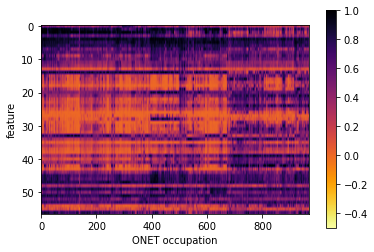

In [10]:
# Plot the work context vectors
plt.imshow(work_context_vectors_rescaled.T, aspect=12, cmap='inferno_r')
plt.colorbar()
plt.xlabel('ONET occupation')
plt.ylabel('feature')
plt.show()

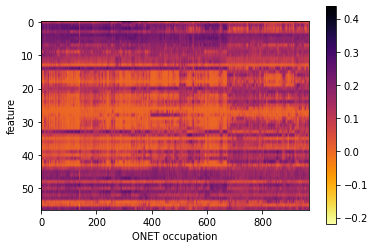

In [11]:
# Plot the normalised work context vectors
plt.imshow(work_context_vectors_norm.T, aspect=12, cmap='inferno_r')
plt.colorbar()
plt.xlabel('ONET occupation')
plt.ylabel('feature')
plt.show()

## 1.4 Check examples

In [12]:
# Check the vector of a random ONET occupation
# sort the work context features based on their intensity ('vector_value_norm')
i = np.random.randint(len(unique_onets))
onet = unique_onets[i]
df = onet_work_context[(onet_work_context['O*NET-SOC Code']==onet) &
                       (onet_work_context['Scale ID'].isin(['CX','CT']))].sort_values('Element ID').copy().reset_index(drop=True)
df = df[['O*NET-SOC Code', 'Title', 'Element ID', 'Element Name', 'Data Value']]
df['vector_value'] = work_context_vectors[i,:]
df['vector_value_rescaled'] = work_context_vectors_rescaled[i,:]
df['vector_value_norm'] = work_context_vectors_norm[i,:]
df.sort_values('vector_value_norm', ascending=False)


,O*NET-SOC Code,Title,Element ID,Element Name,Data Value,vector_value,vector_value_rescaled,vector_value_norm
42,47-2031.02,Rough Carpenters,4.C.2.e.1.d,Wear Common Protective or Safety Equipment suc...,4.93,4.93,0.9825,0.207517
4,47-2031.02,Rough Carpenters,4.C.1.a.2.l,Face-to-Face Discussions,4.77,4.77,0.9425,0.199068
5,47-2031.02,Rough Carpenters,4.C.1.a.4,Contact With Others,4.75,4.75,0.9375,0.198012
47,47-2031.02,Rough Carpenters,4.C.3.a.4,Freedom to Make Decisions,4.70,4.70,0.9250,0.195372
34,47-2031.02,Rough Carpenters,4.C.2.d.1.b,Spend Time Standing,4.63,4.63,0.9075,0.191676
6,47-2031.02,Rough Carpenters,4.C.1.b.1.e,Work With Work Group or Team,4.45,4.45,0.8625,0.182171
21,47-2031.02,Rough Carpenters,4.C.2.b.1.a,"Sounds, Noise Levels Are Distracting or Uncomf...",4.40,4.40,0.8500,0.179531
31,47-2031.02,Rough Carpenters,4.C.2.c.1.e,Exposed to Hazardous Equipment,4.38,4.38,0.8450,0.178475
49,47-2031.02,Rough Carpenters,4.C.3.b.4,Importance of Being Exact or Accurate,4.35,4.35,0.8375,0.176891
16,47-2031.02,Rough Carpenters,4.C.2.a.1.c,"Outdoors, Exposed to Weather",4.33,4.33,0.8325,0.175835


# 2. Assign work context vectors to ESCO occupations

In [13]:
# Add a zero-vector that will be assigned to ESCO occupations without a crosswalked ONET occupation
work_context_vectors_norm_z = np.concatenate((work_context_vectors_norm, np.zeros((1,len(unique_features)))), axis=0)
work_context_vectors_rescaled_z = np.concatenate((work_context_vectors_rescaled, np.zeros((1,len(unique_features)))), axis=0)

work_context_vectors_rescaled_z.shape


(969, 57)

In [14]:
# Dataframe with the unique ONET codes in the Work Context dataset
unique_onets_df = pd.DataFrame(data={'onet_code': unique_onets, 'j': list(range(len(unique_onets)))})

# Dataframe linking ESCO occupation to a work context vector
esco_to_work_context_vector = esco_onet_xwalk.merge(unique_onets_df, on='onet_code', how='left')

# ESCO occupations without work contexts
esco_no_work_context = esco_to_work_context_vector[esco_to_work_context_vector['j'].isnull()].id.to_list()


### Cases with missing work context features 

Note that several ESCO occupations don't have corresponding work context vectors. This is either because the ESCO occupations are military occupations, which were not included in the crosswalk between ESCO and O\*NET, or because their corresponding O\*NET occupations had not been assigned work context features at the time of performing this analysis. Most of these cases arise due to the crosswalked O\*NET occupation being very general, i.e. they are of the '.., all other' type.

Presently, we leave these ESCO occupations without their work context vectors - however, going forward, their work context vectors could be inferred from newer versions of O\*NET, if possible, or they could be imputed using the values from the most similar other occupation.

In [15]:
print(f"{len(esco_no_work_context)} ESCO occupations do not have work context vectors")

84 ESCO occupations do not have work context vectors


In [16]:
# ONET occupations without work context vectors
pd.set_option('max_colwidth', 200)
esco_onet_xwalk.loc[esco_no_work_context][['onet_code','onet_occupation']].drop_duplicates().sort_values('onet_code')

,onet_code,onet_occupation
1359,11-1031.00,legislators
2438,11-3031.00,financial managers
1451,11-3071.00,"transportation, storage, and distribution managers"
49,11-9199.00,"managers, all other"
1591,17-3019.00,"drafters, all other"
458,17-3031.00,surveying and mapping technicians
2650,19-1031.00,conservation scientists
1023,19-3099.00,"social scientists and related workers, all other"
293,19-4051.00,nuclear technicians
2003,19-4099.00,"life, physical, and social science technicians, all other"


In [17]:
# Assign the zero-vector to the ESCO occupations without work context data
esco_to_work_context_vector['has_vector'] = True
esco_to_work_context_vector.loc[esco_no_work_context, 'has_vector'] = False
esco_to_work_context_vector.loc[esco_no_work_context, 'j'] = len(work_context_vectors_norm_z)-1

# Create the normalised ESCO work context vectors
work_context_vectors_esco_norm = work_context_vectors_norm_z[esco_to_work_context_vector['j'].astype(int).to_list(),:]
print(work_context_vectors_esco_norm.shape)

# Create the non-normalised ESCO work context vectors
work_context_vectors_esco = work_context_vectors_rescaled_z[esco_to_work_context_vector['j'].astype(int).to_list(),:]
print(work_context_vectors_esco.shape)


(2942, 57)
(2942, 57)


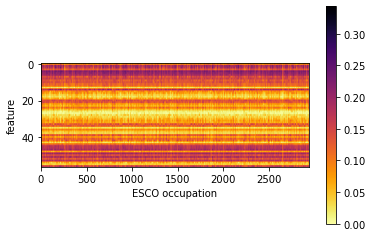

In [18]:
# Plot normalised work context vectors of ESCO occupations
plt.imshow(work_context_vectors_esco_norm.T, aspect=20, cmap='inferno_r')
plt.colorbar()
plt.xlabel('ESCO occupation')
plt.ylabel('feature')
plt.show()

### 2.1 Check examples

In [22]:
occupations[occupations.preferred_label.str.contains('concierge')]

,id,concept_type,concept_uri,preferred_label,isco_level_1,isco_level_2,isco_level_3,isco_level_4,is_top_level,is_second_level,is_third_level,is_fourth_level,parent_occupation_id,top_level_parent_id
329,329,Occupation,http://data.europa.eu/esco/occupation/1ae8d28e-407c-48ab-88ff-4cb25bfcdea6,hotel concierge,4,42,422,4229,True,False,False,False,NaN,329


In [23]:
# Check the work context vector of a random ESCO occupation
i = np.random.randint(len(occupations))
i = 329
print(i, occupations.loc[i].preferred_label)
df = pd.DataFrame({'Element Name': unique_features,
                   'vector_value_norm': work_context_vectors_esco_norm[i,:],
                   'vector_value_rescaled': work_context_vectors_esco[i,:]})
df.sort_values('vector_value_norm', ascending=False)


329 hotel concierge


,Element Name,vector_value_norm,vector_value_rescaled
1,Telephone,0.258603,1.0000
2,Electronic Mail,0.258603,1.0000
5,Contact With Others,0.247612,0.9575
7,Deal With External Customers,0.247612,0.9575
4,Face-to-Face Discussions,0.230803,0.8925
14,"Indoors, Environmentally Controlled",0.224338,0.8675
47,Freedom to Make Decisions,0.221752,0.8575
53,Time Pressure,0.212701,0.8225
6,Work With Work Group or Team,0.206882,0.8000
51,Structured versus Unstructured Work,0.204296,0.7900


# 3. Compare ESCO occupations' work context vectors

We calculated pairwise Euclidean distances between all vectors, applied min-max normalisation to rescale the distances between zero and one, and converted the normalised distances to similarities.

Note that, alternatively, the similarity between work context feature vectors could also be computed using other distance metrics, such as cosine similarity. However, for consistency purposes, here we used the same approach as for work activity feature vectors.

## 3.1 Calculate similarities

In [23]:
# Distances
D_work_context = squareform(pdist(work_context_vectors_esco_norm, metric='euclidean'))
D_work_context.shape

(2942, 2942)

In [24]:
# Normalise the distances between 0 and 1 and caclulate similarities
D_work_context_norm = (D_work_context-np.min(D_work_context))/(np.max(D_work_context)-np.min(D_work_context))
W_work_context_norm = 1 - D_work_context_norm

## 3.2 Check examples

### Distributions

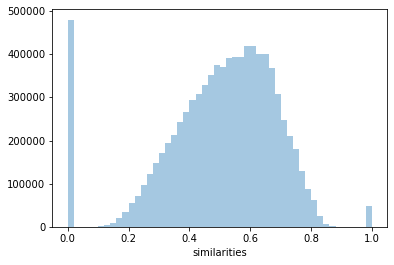

In [25]:
# Distribution of similarities
sns.distplot(W_work_context_norm.flatten(), kde=False)
plt.xlabel('similarities')
plt.show()

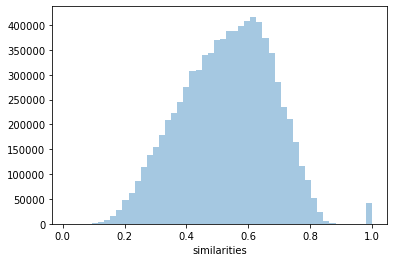

In [26]:
# Check if the tail near 0 is due to the missing work contexts
esco_with_work_context = esco_to_work_context_vector[esco_to_work_context_vector.has_vector==True].id.to_list()
W_ = W_work_context_norm
W_ = W_[esco_with_work_context, :]
W_ = W_[:, esco_with_work_context]

sns.distplot(W_.flatten(), kde=False)
plt.xlabel('similarities')
plt.show()

### Closest occupations based on work context similarity

In [27]:
# Choose a random occupation (or set occupation_id to some id)
occupation_id = np.random.randint(len(occupations))

# Print occupation's name
row = occupations.loc[occupation_id]
print(f"id: {row.id}, label: {row.preferred_label}")

# Find the closest neighbours
closest = compare_nodes_utils.find_closest(occupation_id, W_work_context_norm, occupations[['preferred_label']])
closest.head(20)

id: 2520, label: rental service representative in video tapes and disks


,preferred_label,similarity
1704,rental service representative in construction and civil engineering machinery,1.00000
532,rental service representative in personal and household goods,1.00000
2520,rental service representative in video tapes and disks,1.00000
733,vehicle rental agent,1.00000
1027,rental service representative in office machinery and equipment,1.00000
934,rental service representative in water transport equipment,1.00000
1918,rental service representative in trucks,1.00000
1958,rental service representative in recreational and sports goods,1.00000
2852,rental service representative in cars and light motor vehicles,1.00000
1152,rental service representative in air transport equipment,1.00000


### Show which ESCO occupations don't have work context features

In [28]:
for j, row in esco_to_work_context_vector[esco_to_work_context_vector.has_vector==False].sort_values('isco_level_4').iterrows():
    print(row.isco_level_4, row.preferred_label)


110 navy officer
110 colonel
110 brigadier
110 lieutenant
110 army general
110 artillery officer
110 armed forces officer
110 squadron leader
110 army major
110 fleet commander
110 air force officer
110 army captain
210 special forces officer
210 army corporal
210 warfare specialist
210 sergeant
310 intelligence communications interceptor
310 bomb disposal technician
310 air force pilot
310 infantry soldier
310 military engineer
1111 senator
1111 city councillor
1219 project manager
1324 pipeline superintendent
1346 pension scheme manager
1349 legal service manager
1349 commercial art gallery manager
1349 service manager
1349 rescue centre manager
1349 translation agency manager
1349 correctional services manager
1349 front of house manager
1349 interpretation agency manager
1349 aviation communications and frequency coordination manager
1431 betting manager
1431 beauty salon manager
1431 zoo curator
1431 sport facility manager
1431 cultural centre director
1431 performance production 

# 4. Compare the approach with using cosine similarity

In [29]:
# Similarities
D_cos = squareform(pdist(work_context_vectors_esco, metric='cosine'))
D_cos[np.isnan(D_cos)]=1
W_cos = 1 - D_cos

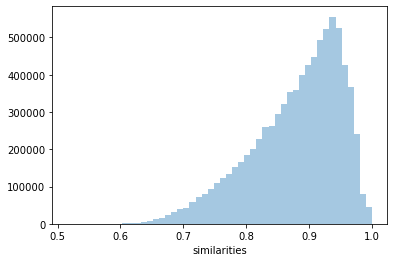

In [30]:
# Distribution of similarities
esco_with_work_context = esco_to_work_context_vector[esco_to_work_context_vector.has_vector==True].id.to_list()
W_ = W_cos.copy()
W_ = W_[esco_with_work_context, :]
W_ = W_[:, esco_with_work_context]

sns.distplot(W_.flatten(), kde=False)
plt.xlabel('similarities')
plt.show()

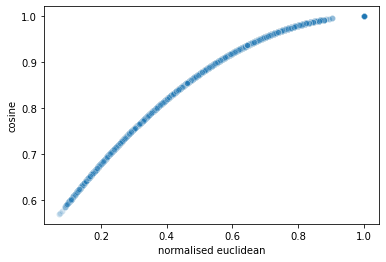

In [31]:
# Show that the two distance metrics are strongly correlated in this case
W_1 = W_cos.copy()
W_1 = W_1[esco_with_work_context, :]
W_1 = W_1[:, esco_with_work_context]

W_2 = W_work_context_norm.copy()
W_2 = W_2[esco_with_work_context, :]
W_2 = W_2[:, esco_with_work_context]

random_sample = np.random.permutation(len(W_1.flatten()))[1:400000]
sns.scatterplot(W_2.flatten()[random_sample],
                W_1.flatten()[random_sample],
                alpha=0.2)
plt.xlabel('normalised euclidean')
plt.ylabel('cosine')
plt.show()

# 5. Export similarity matrices & vectors

## 5.1 Similarity matrices

In [32]:
# Create a version of the similarity matrix with nulls for occupations without work context vectors
W_work_context_norm_nan = W_work_context_norm.copy()
W_work_context_norm_nan[esco_no_work_context,:] = np.nan
W_work_context_norm_nan[:,esco_no_work_context] = np.nan


In [33]:
# Save the similarity matrices
np.save(f'{output_folder}OccupationSimilarity_ONET_Work_Context.npy', W_work_context_norm)
np.save(f'{output_folder}OccupationSimilarity_ONET_Work_Context_nan.npy', W_work_context_norm_nan)


## 5.2 Work context vectors

In [34]:
# Save the work context vectors
np.save(f'{data_folder}interim/work_context_features/ESCO_work_context_vectors_norm.npy', work_context_vectors_esco_norm)
np.save(f'{data_folder}interim/work_context_features/ESCO_work_context_vectors.npy', work_context_vectors_esco)


## 5.3 Work context features

In [35]:
# Create a dataframe describing the elements of the work context vector
df = pd.DataFrame({
    'vector_element': list(range(len(unique_features))),
    'element_name': unique_features,
    'element_id': unique_features_id})
df.to_csv(data_folder + 'processed/work_context_vector_features.csv', index=False)

# Dataframe containing information about the links between ESCO and ONET
# (used to assign work context vectors to ESCO)
esco_to_work_context_vector.to_csv(data_folder + 'interim/work_context_features/occupations_work_context_vector.csv', index=False)
